# Machine Learning (CS-433)
## Class Project 1 - Higgs Boson
Simon Canales, Jordan Willemin, Claudio Loureiro

In [1]:
import numpy as np

from proj1_helpers import *
from implementations import *
from utils import *
from cross_validation import *

# Plot libraries
import matplotlib
import matplotlib.pyplot as plt

## Loading data

In [2]:
training_pred, training_data, ids_tr = load_csv_data("../data/train.csv")
testing_pred, testing_data, ids_te = load_csv_data("../data/test.csv")

## First model

First we can check if the two predictions are well distributed when taking all our training set. In other words, we will check if the proportion of 1 is the same as the -1.

In [3]:
prop_of1 = np.sum(np.equal(training_pred, 1)) / len(training_pred)
print('We have a proportion {} of ones and {} for minus ones'.format(prop_of1, 1-prop_of1))

We have a proportion 0.342668 of ones and 0.657332 for minus ones


For our baseline model we can see for our categoritical feature what are the proportions of 1 and -1 for each category

In [4]:
categoritical_data = training_data[:,22]

pred_with0 = training_pred[categoritical_data == 0]
pred_with1 = training_pred[categoritical_data == 1]
pred_with2 = training_pred[categoritical_data == 2]
pred_with3 = training_pred[categoritical_data == 3]

statistics0 = np.sum(np.equal(pred_with0, 1)) / len(pred_with0)
statistics1 = np.sum(np.equal(pred_with1, 1)) / len(pred_with1)
statistics2 = np.sum(np.equal(pred_with2, 1)) / len(pred_with2)
statistics3 = np.sum(np.equal(pred_with3, 1)) / len(pred_with3)

print('We have a proportion of {} of ones and {} of minus ones for category 0'.format(statistics0, 1-statistics0))
print('We have a proportion of {} of ones and {} of minus ones for category 1'.format(statistics1, 1-statistics1))
print('We have a proportion of {} of ones and {} of minus ones for category 2'.format(statistics2, 1-statistics2))
print('We have a proportion of {} of ones and {} of minus ones for category 3'.format(statistics3, 1-statistics3))

We have a proportion of 0.2551419735169598 of ones and 0.7448580264830402 of minus ones for category 0
We have a proportion of 0.35734550706695556 of ones and 0.6426544929330444 of minus ones for category 1
We have a proportion of 0.5108080747930686 of ones and 0.48919192520693144 of minus ones for category 2
We have a proportion of 0.3036906695542321 of ones and 0.6963093304457679 of minus ones for category 3


## Preprocessing

First let's observe some features in order to see the problems that we may have with the dataset.

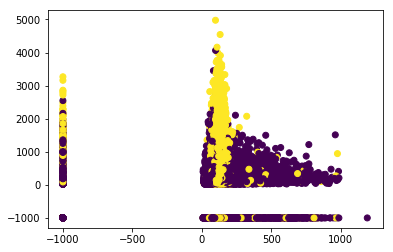

In [5]:
xx = training_data[:,[0,5]]
plt.scatter(xx[:,0], xx[:,1], c = training_pred)
plt.show()

We see that there is a lot of data around -999, this data is in fact wrong values. So as a first step we set it for now to 0 and this will be then treated correctly when standardizing in cross-validation (we will ignore these values to not have influences on the mean). Also there is a column that contains only 0, 1 and 2. Thus we increase this feature by 1 in order to not be considered as invalid value by the standardization. As these values seem to be used for classification, the impact should be minor if we add 1 to these.

In [6]:
wrong_value = -999
training_data[training_data==wrong_value] = 0
testing_data[testing_data==wrong_value] = 0
training_data[:, 22] += 1
training_data[:,12] += 0.0000001

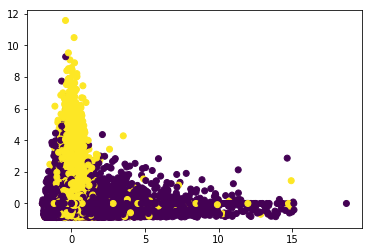

In [8]:
xx[xx==wrong_value] = 0
standard, _=standardize(xx, 0)
plt.scatter(standard[:,0],standard[:,1], c = training_pred)
plt.show()

Here is the plot that we obtain after standardization and after taking care of the invalid values. In this case we could already imagine a separation between these two features. Thus this gives us a hint that these features are quite important.

Then by observing the data since there is a lot of missing values for the two last features, one could try to delete these ones and see if the results improve.

In [11]:
training_data = np.delete(training_data, 29, axis = 1)
training_data = np.delete(training_data, 28, axis = 1)

## Least Squares Gradient Descent

We start with the least squares gradient descent. We fit a polynomial to our input data of degree 2. Then we do our cross-validation with $k_{fold} = 5$. After testing some values we quickly remark that increasing the maximum iterations above 100 and decreasing gamma below 0.01 does no longer increase the accuracy dramtically.

In [12]:
poly_degree = 2
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 0.01

k_fold = 4
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares_GD, 
                                                                                   compute_mse, tx, training_pred, indexes_te, 
                                                                                   indexes_tr, k_fold, True, 
                                                                                   (initial_w, max_iters, gamma))

print('Mse: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Mse:  0.352052439157672
Rmse:  0.8391095746774339
Accuracy:  0.7479120000000001


### Tuning learning rate gamma

In [38]:
poly_degree = 2
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gammas_vec = np.logspace(-1, -6, 6) 
k_fold = 5

accuracy_vec = []

for gamma in gammas_vec:
    indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
    mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares_GD, 
                                                                                       compute_mse, tx, training_pred, indexes_te, 
                                                                                       indexes_tr, k_fold, True, 
                                                                                       (initial_w, max_iters, gamma))
    accuracy_vec.append(accuracy)

Mse:  0.49992584218339103
Rmse:  0.9999258394334962
Accuracy:  0.697964


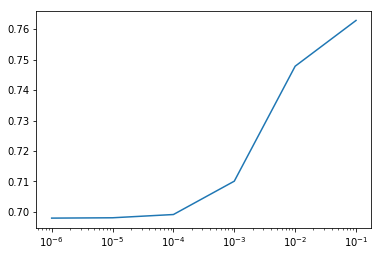

In [41]:
plt.semilogx(gammas_vec, accuracy_vec)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.show()

The accuracy decreases as we decrease gamma.

### Tuning maximal iterations

In [19]:
poly_degree = 2
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])
max_iters_vec = np.linspace(20, 300, 15) 
gamma = 0.01
k_fold = 5

accuracy_vec = []

for max_iters in max_iters_vec:
    indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
    mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares_GD, 
                                                                                       compute_mse, tx, training_pred, indexes_te, 
                                                                                       indexes_tr, k_fold, True, 
                                                                                       (initial_w, int(max_iters), gamma))
    accuracy_vec.append(accuracy)

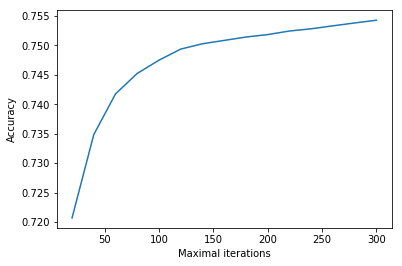

In [20]:
plt.plot(max_iters_vec, accuracy_vec)
plt.ylabel('Accuracy')
plt.xlabel('Maximal iterations')
plt.show()

### Tuning polynomial degree

In [9]:
poly_degrees_vec = np.linspace(2, 8, 7)
max_iters = 100
gamma = 0.01
k_fold = 5

accuracy_vec = []


for poly_degree in poly_degrees_vec:
    tx = build_poly(training_data, int(poly_degree))
    initial_w = np.zeros(tx.shape[1])

    indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
    mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares_GD, 
                                                                                       compute_mse, tx, training_pred, indexes_te, 
                                                                                       indexes_tr, k_fold, True, 
                                                                                       (initial_w, max_iters, gamma))
    accuracy_vec.append(accuracy)

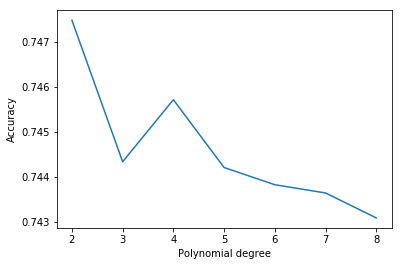

In [13]:
plt.plot(poly_degrees_vec, accuracy_vec)
plt.ylabel('Accuracy')
plt.xlabel('Polynomial degree')
plt.show()

Since the method is not regularized increasing polynomial degree will increase overfitting. Thus for unregularized method we will not increase the polynomial degree above 2 or 3

## Least Squares Stochastic Gradient Descent

Least squares stochastic gradient descent. Agains it works as the least squares gradient descent but at each iteration we only take one sample of the dataset. The we naturally have to do more iterations than the gradient descent. Again we fit a polynomial to the dataset and perform a cross-validation with $k_{fold} = 5$

In [13]:
poly_degree = 3
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])
max_iters = 500
gamma = 0.001

k_fold = 5
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares_SGD, 
                                                                                  compute_mse, tx, training_pred, indexes_te, 
                                                                                  indexes_tr, k_fold, True, 
                                                                                  (initial_w, max_iters, gamma))

print('Mse: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Mse:  0.530699297924142
Rmse:  1.0302420083884583
Accuracy:  0.714812


## Least Squares

Compared to other methods least squares is not an iterative method. Instead we have to resolve a system in order to minimize our weight matrix. Again, we fit a polynomial to the data set of degree 3 and perform a cross-validation with $k_{fold} = 4$ 

In [14]:
poly_degree = 3
tx = build_poly(training_data, poly_degree)

k_fold = 4
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares, 
                                                                                  compute_mse, tx, training_pred, indexes_te, 
                                                                                  indexes_tr, k_fold, True)

print('Mse: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Mse:  0.321535514804831
Rmse:  0.8019170964692435
Accuracy:  0.7857560000000001


## Ridge regression 

The ridge regression is an improved version of the least squares method denoted above. It adds a regularization term. This method proved to be the most efficient in term of accuracy. Thus we will optimize our parameters to achieve the best possible accuracy.

In [15]:
poly_degree = 16
tx = build_poly(training_data, poly_degree)
lambda_ = 1e-15

k_fold = 4
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(ridge_regression, 
                                                                                  compute_mse, tx, training_pred, indexes_te, 
                                                                                  indexes_tr, k_fold, True, (lambda_,))

print('Mse: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Mse:  937679458.2362735
Rmse:  43305.41440134879
Accuracy:  0.819116


### Tuning lambda for ridge regression

First we will try to find the lambda that gives us the best accuracy. We will iterate through a list of lambdas and perform a cross validation for each.

In [16]:
poly_degree = 12
tx = build_poly(training_data, poly_degree)
lambda_vec = np.logspace(-6, -17, 12)
accuracy_vec = []

k_fold = 4

indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)

for lambda_ in lambda_vec:
    mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(ridge_regression, 
                                                                                      compute_mse, tx, training_pred, indexes_te, 
                                                                                      indexes_tr, k_fold, True, (lambda_,))
    accuracy_vec.append(accuracy)

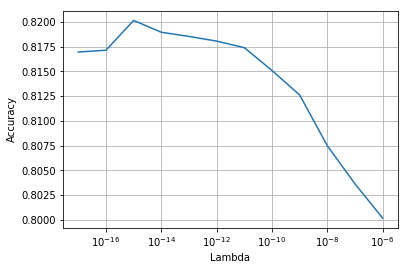

In [17]:
plt.semilogx(lambda_vec, accuracy_vec)
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

### Tune degrees and lambda concurrently

We can try to vary lambda and polynomial degree and denote which parameters give us the best results.

In [29]:
degrees_vec = np.linspace(2, 17, 16)
lambdas_vec = np.logspace(-4, -16, 13)
k_fold = 4

rmse_te_mean_arr = np.zeros((len(lambdas_vec), len(degrees_vec)))
mse_te_mean_arr = np.zeros_like(rmse_te_mean_arr)
accuracy_arr = np.zeros_like(rmse_te_mean_arr)

for i, degree in enumerate(degrees_vec):
    tx = build_poly(training_data, int(degree))
    indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
    for j, lambda_ in enumerate(lambdas_vec):
        mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(ridge_regression, 
                                                                                    compute_mse, tx, training_pred, indexes_te, 
                                                                                    indexes_tr, k_fold, True, (lambda_,))
        accuracy_arr[j][i] = accuracy
        print(j,i)
        print(accuracy)

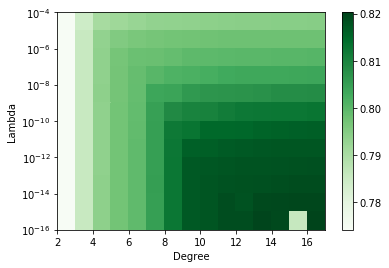

In [50]:
cbar = plt.pcolor(degrees_vec, lambdas_vec,accuracy_arr, cmap='Greens') 
plt.xlabel('Degree')
plt.ylabel('Lambda')
plt.yscale('log')
plt.colorbar()
plt.show()

In [24]:
accuracy_arr = np.genfromtxt('acc.csv', delimiter = ',')
degrees_vec = np.linspace(2, 17, 16)
lambdas_vec = np.logspace(-4, -16, 13)

In [28]:
indices = np.where(accuracy_arr == accuracy_arr.max())
best_lambda = lambdas_vec[indices[0]]
best_degree = degrees_vec[indices[1]]
print('Best Lambda {}'.format(float(best_lambda)))
print('Best polynomial degree {}'.format(int(best_degree)))

Best Lambda 1e-15
Best polynomial degree 16


## Logistic regression

We perform then a logistic regression which would fit for our problem because this type of method is focused on classification. Since the logistic regression needs prediction to be 0 or 1 we will update our training predictions.

Then we produce as before a cross-validation for different parameters.

In [19]:
training_pred_log = training_pred.copy()
training_pred_log[training_pred_log==-1] = 0
poly_degree = 9
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])

max_iters = 200
gamma = 0.00005

k_fold = 4
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(logistic_regression, loss_logistic_regression,
                                                                                  tx, training_pred_log, indexes_te, 
                                                                                  indexes_tr, k_fold, True, 
                                                                                  (initial_w, max_iters, gamma))

print('Negative log likelihood: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Negative log likelihood:  0.6897017048065767
Rmse:  1.1744800592658666
Accuracy:  0.6913640000000001


## Regularized Logistic Regression

This works the same way as the logistic regression except that we add a regularization term for the loss function. The parameters are tuned manually to obtain the best accuracy.

In [21]:
poly_degree = 10
tx = build_poly(training_data, poly_degree)
initial_w = np.zeros(tx.shape[1])

lambda_ = 0.8
max_iters = 200
gamma = 0.00001

k_fold = 4
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(reg_logistic_regression, 
                                                                                  reg_logistic_regression_loss,
                                                                                  tx, training_pred_log, indexes_te, 
                                                                                  indexes_tr, k_fold, True, 
                                                                                  (lambda_, initial_w, max_iters, gamma),
                                                                                  (lambda_,))

print('Negative log likelihood: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Negative log likelihood:  0.6924156820830654
Rmse:  1.176788580912532
Accuracy:  0.6918
